In [3]:
import sys
sys.path.append('../utils/') 


import argparse
import torch
from tqdm import tqdm
import os
import subprocess
from PIL import Image
import numpy as np
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset  # Make sure to include Subset here
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm  # Use notebook version of tqdm for Jupyter
from sklearn.metrics import f1_score, cohen_kappa_score
import torch.optim as optim
import torch
import torch.nn as nn
!pip install torchvision
from torchvision import models
import base64
from torch.utils.data import Dataset
!pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import numpy as np
import torch
from torchvision.transforms import ToTensor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np


#from utils.model_utilities_cbam import ChannelAttention, SpatialAttention, CBAM, CBAMBottleneck







Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:


def download_dataset():
    # Ensure the .kaggle directory exists
    os.makedirs(os.path.join(os.path.expanduser('~'), '.kaggle'), exist_ok=True)

    # Download the dataset from Kaggle
    subprocess.run(['kaggle', 'datasets', 'download', '-d', 'ninadaithal/imagesoasis', '--unzip', '-p', 'data/'])
    
     # Confirmation message
    print("Download completed and files are extracted to the 'data/' directory.")


if __name__ == "__main__":
    download_dataset()


100%|██████████| 1.23G/1.23G [00:05<00:00, 255MB/s]



Download completed and files are extracted to the 'data/' directory.


In [5]:
# Define a custom transform to convert grayscale images to RGB by expanding the channel
class ExpandChannelTransform(object):
    def __call__(self, tensor):
        # Ensure that we are given a tensor, not a PIL Image
        if not isinstance(tensor, torch.Tensor):
            raise TypeError('The input to ExpandChannelTransform must be a tensor')
        # Expand the single grayscale channel to three channels
        return tensor.expand(3, -1, -1)

# Define augmentation transforms for training
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ToTensor(),
    ExpandChannelTransform(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization
])

# Define basic transforms for validation and test
basic_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    ExpandChannelTransform(),  # Custom transform to expand the channel
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization
])

class_specific_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # More rotation
    transforms.RandomResizedCrop(128, scale=(0.5, 1.0), ratio=(0.75, 1.33)),  # More scale variation
    # ... other potentially aggressive transformations
    transforms.ToTensor(),
    ExpandChannelTransform(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Define your dataset directory and classes
dataset_dir = '/home/ubuntu/Deep-Learning-Final-Project/src/data/Data'
classes = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.paths = []
        self.labels = []
        self.transform = transform
        self.target_transform = target_transform  # New attribute for class-specific transforms
        
        
        # Iterate over all class names
        for label, class_name in enumerate(classes):
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith('.jpg'):
                    self.paths.append(os.path.join(class_dir, filename))
                    self.labels.append(label)  # Assign labels based on class

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB
        
        # Apply class-specific augmentation
        if label in [1, 2] and self.target_transform:
            image = self.target_transform(image)
        elif self.transform:
            image = self.transform(image)
        
        return image, label


In [6]:
# Load your dataset
full_dataset = AlzheimerDataset(root_dir=dataset_dir, transform=basic_transforms)

# Split dataset into train, validation, and test sets
train_idx, test_idx = train_test_split(
    np.arange(len(full_dataset)),
    test_size=0.2,
    shuffle=True,
    stratify=full_dataset.labels
)
train_idx, val_idx = train_test_split(
    train_idx,
    test_size=0.25,
    shuffle=True,
    stratify=[full_dataset.labels[i] for i in train_idx]
)

# Create DataLoaders for each set
train_data = Subset(full_dataset, train_idx)
val_data = Subset(full_dataset, val_idx)
test_data = Subset(full_dataset, test_idx)

# Update transformations for the training dataset
train_data.dataset.transform = train_transforms

In [7]:
# Define the batch size for the data loaders
batch_size = 32

# Create data loaders for the train, validation, and test subsets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Training Data: {len(train_data)} samples")
print(f"Validation Data: {len(val_data)} samples")
print(f"Testing Data: {len(test_data)} samples")


Training Data: 51861 samples
Validation Data: 17288 samples
Testing Data: 17288 samples


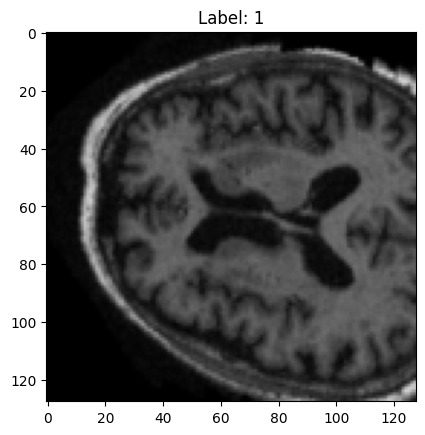

Class distribution in training set: Counter({0: 40332, 1: 8235, 2: 3001, 3: 293})
Class distribution in validation set: Counter({0: 13445, 1: 2745, 2: 1001, 3: 97})
Class distribution in testing set: Counter({0: 13445, 1: 2745, 2: 1000, 3: 98})


In [8]:

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def show_image(img, label):
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # Revert normalization
    img = np.clip(img, 0, 1)  # Ensure pixel values are within [0, 1]

    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.show()

# Display the first image in the training set
image, label = train_data[0]
show_image(image, label)


from collections import Counter

train_labels = [label for _, label in train_data]
val_labels = [label for _, label in val_data]
test_labels = [label for _, label in test_data]

print(f"Class distribution in training set: {Counter(train_labels)}")
print(f"Class distribution in validation set: {Counter(val_labels)}")
print(f"Class distribution in testing set: {Counter(test_labels)}")


In [31]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Ensure that targets and inputs are on the same device
        if inputs.device != targets.device:
            targets = targets.to(inputs.device)
            
        # Convert targets to one-hot encoding
        targets_one_hot = torch.eye(inputs.size(-1), device=inputs.device)[targets]

        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets_one_hot, reduction='none', weight=self.weight)
        pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss



In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # Adjust the input features
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print("Input size:", x.size())
        avg_pooled = self.avg_pool(x)
        max_pooled = self.max_pool(x)
        #print("Avg pooled size:", avg_pooled.size())
        #print("Max pooled size:", max_pooled.size())
        
        avg_out = self.fc2(self.relu1(self.fc1(avg_pooled)))
        max_out = self.fc2(self.relu1(self.fc1(max_pooled)))
        out = avg_out + max_out
        
        scale = self.sigmoid(out)  # Sigmoid activation
        return x * scale.expand_as(x)  # Scale the input

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print("Input size:", x.size())
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        #print("Avg out size:", avg_out.size())
        #print("Max out size:", max_out.size())
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv1(x_cat)
        scale = self.sigmoid(x_out)  # Sigmoid activation
        return x * scale  # Scale the input


class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelAttention(gate_channels, reduction_ratio)
        self.SpatialGate = SpatialAttention()

    def forward(self, x):
        # Apply Channel Attention
        channel_attention_map = self.ChannelGate(x)
        x = x * channel_attention_map.expand_as(x)
        
        # Apply Spatial Attention
        spatial_attention_map = self.SpatialGate(x)
        # The spatial attention map is 1xHxW, and needs to be broadcasted across the channel dimension
        # You should not multiply x by x_out again, as it has already been modified by the channel attention
        x = x * spatial_attention_map.expand_as(x)
    
        return x

    
class CBAMBottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(CBAMBottleneck, self).__init__()
        # Assuming 'out_planes' is 4 times 'in_planes' for a bottleneck
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.conv3 = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.cbam = CBAM(out_planes)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        out = self.cbam(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out



In [12]:
# Create a dummy input tensor mimicking the output of your last conv layer
dummy_input = torch.randn(1, 32, 32, 32)  # Batch size 1, 32 channels, 32x32 feature map

# Instantiate CBAM and test it
cbam = CBAM(32)  # Assuming 32 is the correct number of input channels
with torch.no_grad():
    cbam_output = cbam(dummy_input)
    print("CBAM output size:", cbam_output.size())

dummy_input = torch.randn(1, 32, 32, 32)
channel_attention = ChannelAttention(32)
with torch.no_grad():
    channel_attention_output = channel_attention(dummy_input)
    print("Channel Attention output size:", channel_attention_output.size())

spatial_attention = SpatialAttention()
with torch.no_grad():
    spatial_attention_output = spatial_attention(dummy_input)
    print("Spatial Attention output size:", spatial_attention_output.size())



CBAM output size: torch.Size([1, 32, 32, 32])
Channel Attention output size: torch.Size([1, 32, 32, 32])
Spatial Attention output size: torch.Size([1, 32, 32, 32])


In [21]:
class AttentionCNN(nn.Module):
    def __init__(self, num_classes):
        super(AttentionCNN, self).__init__()
        # Assume the input image size is 128x128
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # Output size: 128x128
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2) # Output size: 64x64
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # Output size: 64x64
        self.bn2 = nn.BatchNorm2d(32)
        # Maybe only one pooling layer is needed, so we'll comment out the next pooling line.
        # self.pool = nn.MaxPool2d(2, 2) # Commented out to prevent over-reduction
        self.cbam = CBAM(32) # Attention mechanism

        # Calculate the correct total number of features after the conv and pool layers
        # For example, if after the pooling layer you have a 32x32 feature map with 32 channels:
        # self.fc1 = nn.Linear(32 * 32 * 32, 120)
        # You will need to calculate the correct size here based on your actual output.
        
        # Finally, define the fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 32, 120) # Adjust this size accordingly
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        #print("Size after conv1 and relu:", x.size())
        x = self.pool(x)
       # print("Size after pool1:", x.size())
        x = F.relu(self.bn2(self.conv2(x)))
        #print("Size after conv2 and relu:", x.size())
        x = self.pool(x)
        #print("Size after pool2:", x.size())
        x = self.cbam(x)
        #print("Size after CBAM:", x.size())
        x = x.view(x.size(0), -1)
        #print("Size before fc1:", x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Instantiate and test the model
model = AttentionCNN(num_classes=4)
dummy_input = torch.randn(1, 3, 128, 128)  # Change from (1, 1, 128, 128) to (1, 3, 128, 128)
with torch.no_grad():
    model(dummy_input)



In [22]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=1, padding='same'),
            nn.ReLU(),
            SEBlock(32),  # SE block inserted here
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding='same'),
            nn.ReLU(),
            SEBlock(64),  # SE block inserted here
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # Adjust the input features based on your image size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [23]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes=4):
        super(DenseNet121, self).__init__()
        densenet121 = models.densenet121(pretrained=True)
        self.features = densenet121.features
        # Add new fully connected layer for classification
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out


In [24]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet50, self).__init__()
        resnet50 = models.resnet50(pretrained=True)
        # Remove the last fully connected layer
        self.features = nn.Sequential(*list(resnet50.children())[:-1])
        # Add new fully connected layer for classification
        self.classifier = nn.Linear(resnet50.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x




In [19]:
class VGG11(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG11, self).__init__()
        self.features = self._make_layers()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def _make_layers(self):
        layers = []
        in_channels = 3 # Update to 3 for RGB images
        cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x




Class sample counts: [67222 13725  5002   488]
Model saved: Validation F1 score improved to 0.7783
Epoch 1/10 completed. Avg Train Loss: 0.04575, Avg Val Loss: 0.03233, Train F1: 0.5942, Val F1: 0.7783
Epoch 1/10
Training Loss: 0.0458, Validation Loss: 0.0323
Training Accuracy: 0.8459, Validation Accuracy: 0.8959
Training F1: 0.5942, Validation F1: 0.7783
Model saved: Validation F1 score improved to 0.8375
Epoch 2/10 completed. Avg Train Loss: 0.02215, Avg Val Loss: 0.02235, Train F1: 0.8623, Val F1: 0.8375
Epoch 2/10
Training Loss: 0.0221, Validation Loss: 0.0223
Training Accuracy: 0.9343, Validation Accuracy: 0.9335
Training F1: 0.8623, Validation F1: 0.8375
Model saved: Validation F1 score improved to 0.9130
Epoch 3/10 completed. Avg Train Loss: 0.01223, Avg Val Loss: 0.01294, Train F1: 0.9285, Val F1: 0.9130
Epoch 3/10
Training Loss: 0.0122, Validation Loss: 0.0129
Training Accuracy: 0.9672, Validation Accuracy: 0.9651
Training F1: 0.9285, Validation F1: 0.9130
Model saved: Validat

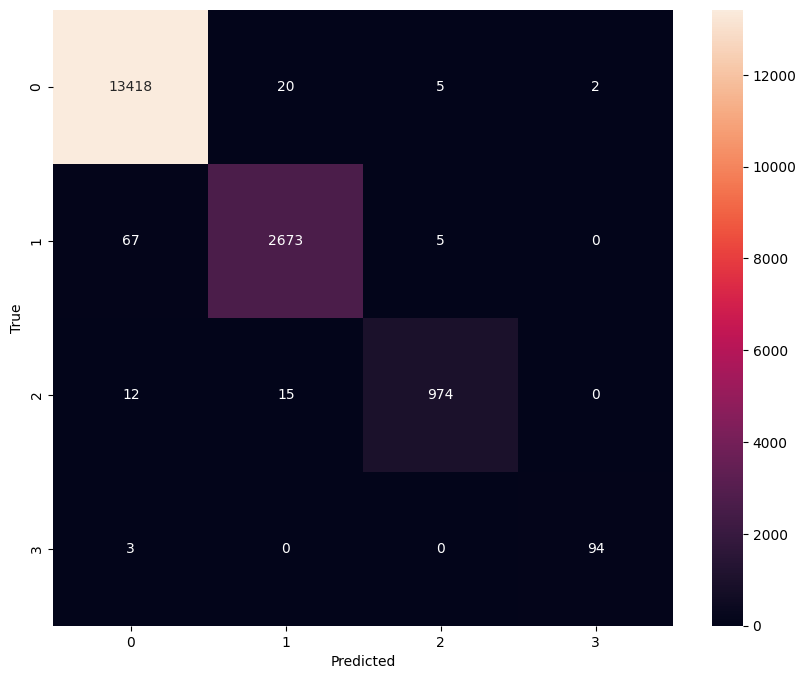

Model saved: Validation F1 score improved to 0.9829
Epoch 10/10 completed. Avg Train Loss: 0.00264, Avg Val Loss: 0.00324, Train F1: 0.9856, Val F1: 0.9829
Epoch 10/10
Training Loss: 0.0026, Validation Loss: 0.0032
Training Accuracy: 0.9935, Validation Accuracy: 0.9925
Training F1: 0.9856, Validation F1: 0.9829


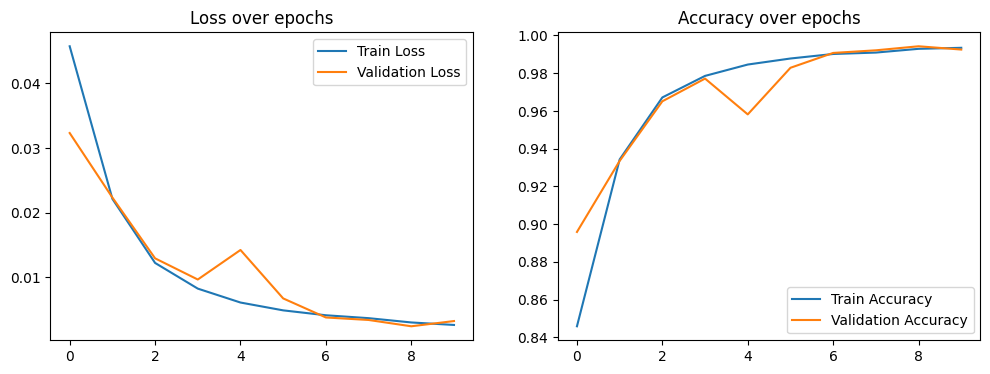

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Training settings
num_epochs = 10
num_classes = 4
model_name = "AttentionCNN"  # Update this to switch between models

# Model selection
if model_name == "SimpleCNN":
    model = SimpleCNN(num_classes=num_classes)
elif model_name == "AttentionCNN":
    model = AttentionCNN(num_classes=num_classes)
elif model_name == "VGG11":
    model = VGG11(num_classes=num_classes)  # Instantiate regular VGG11
elif model_name == "ResNet50":
    model = ResNet50(num_classes=num_classes)  # Instantiate regular ResNet50
elif model_name == "DenseNet121":
    model = DenseNet121(num_classes=num_classes)  # Instantiate regular DenseNet121
else:
    raise ValueError(f"Invalid model selected: {model_name}")




# Calculate the number of samples for each class
class_sample_count = np.array([np.sum(np.array(full_dataset.labels) == class_id) for class_id in range(num_classes)])

print("Class sample counts:", class_sample_count)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the appropriate device

# Calculate class weights and initialize the loss function
class_weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
class_weights = class_weights / class_weights.sum()  # Normalize to sum to 1
class_weights = class_weights.to(device)
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# Instantiate Focal Loss
criterion = FocalLoss(alpha=1, gamma=2)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def train_and_validate(train_ds, val_ds, model, criterion, optimizer, num_epochs, device):
    best_val_f1 = 0.0
    model_save_path = 'model_best_f1.pth'  # Define the model save path
    train_losses = []  # Initialize the list to store training losses
    val_losses = []    # Initialize the list to store validation losses
    train_accuracies = []  # Initialize the list to store training accuracies
    val_accuracies = []    # Initialize the list to store validation accuracies
    train_f1s = []         # Initialize the list to store training F1 scores
    val_f1s = []           # Initialize the list to store validation F1 scores


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []
        for inputs, targets in train_ds:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.view(-1).cpu().numpy())
            train_targets.extend(targets.view(-1).cpu().numpy())
        
        # Validation phase
        model.eval()
        val_loss, val_preds, val_targets = 0.0, [], []
        with torch.no_grad():
            for inputs, targets in val_ds:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.view(-1).cpu().numpy())
                val_targets.extend(targets.view(-1).cpu().numpy())

         # At the end of each epoch
        if epoch == num_epochs - 1:
            # Calculate confusion matrix for the validation set
            cm = confusion_matrix(val_targets, val_preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

        # Calculate metrics after both training and validation phases
        train_f1 = f1_score(train_targets, train_preds, average='macro')
        val_f1 = f1_score(val_targets, val_preds, average='macro')


        # Save the model if the validation F1 score improved
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved: Validation F1 score improved to {val_f1:.4f}")

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} completed. Avg Train Loss: {train_loss/len(train_ds.dataset):.5f}, "
              f"Avg Val Loss: {val_loss/len(val_ds.dataset):.5f}, "
              f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

        
        # Calculate average losses
        train_loss = train_loss / len(train_ds.dataset)
        val_loss = val_loss / len(val_ds.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Calculate accuracy
        train_acc = accuracy_score(train_targets, train_preds)
        val_acc = accuracy_score(val_targets, val_preds)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Calculate F1 score
        train_f1 = f1_score(train_targets, train_preds, average='macro')
        val_f1 = f1_score(val_targets, val_preds, average='macro')
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
        print(f"Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}")

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()

    plt.show()

# Call the training function
train_and_validate(train_loader, val_loader, model, criterion, optimizer, num_epochs, device)







In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(all_targets, all_predictions):
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')
    return precision, recall, f1


def validate_model(val_ds, model, criterion, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for xdata, xtarget in val_ds:
            xdata, xtarget = xdata.to(device), xtarget.to(device)
            output = model(xdata)
            loss = criterion(output, xtarget)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(xtarget.cpu().numpy())

    precision, recall, f1 = calculate_metrics(all_targets, all_predictions)
    print(f"Validation Loss: {val_loss / len(val_ds.dataset):.5f}, F1: {f1:.2f}")


validate_model(val_loader, model, criterion, device=device)

# Testing
def test_model(test_ds, model, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for xdata, xtarget in test_ds:
            xdata, xtarget = xdata.to(device), xtarget.to(device)
            output = model(xdata)
            _, predicted = torch.max(output.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(xtarget.cpu().numpy())

    # Calculate F1 score
    test_f1 = f1_score(all_targets, all_predictions, average='macro')
    print(f"Test F1 Score: {test_f1:.2f}")

test_model(test_loader, model, device=device)


Validation Loss: 0.00010, F1: 0.98
Test F1 Score: 0.98


In [38]:
torch.save(model.state_dict(), 'model.pth')
